In [24]:
library(dplyr)
library(sandwich)
library(xtable)

library(ggplot2)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [1]:
load("../data/wage2015_subsample_inference.Rdata")
attach(data)
dim(data)

[1] 5150   20

In [2]:
#Select data of some college
data_scl<- data[data$scl==1,]

#Select data of college graduated
data_clg<- data[data$clg==1,]

#Combine data to obtaing subset of college-educated-workers
sample <- rbind(data_scl, data_clg)
dim(sample)

[1] 3068   20

In [3]:
library(xtable)

Z <- sample[which(colnames(sample) %in% c("lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"))]

data_female <- sample[sample$sex==1,]
Z_female <- data_female[which(colnames(sample) %in% c("lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"))]


data_male <- sample[sample$sex==0,]
Z_male <- data_male[which(colnames(sample) %in% c("lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"))]

table <- matrix(0, 12, 3)
table[1:12,1]   <- as.numeric(lapply(Z,mean))
table[1:12,2]   <- as.numeric(lapply(Z_male,mean))
table[1:12,3]   <- as.numeric(lapply(Z_female,mean))
rownames(table) <- c("Log Wage","Sex","Less then High School","High School Graduate","Some College","Gollage Graduate","Advanced Degree", "Northeast","Midwest","South","West","Experience")
colnames(table) <- c("All","Men","Women")
tab<- xtable(table, digits = 4)
tab

,All,Men,Women
Log Wage,3.0000223,3.0384121,2.9569035
Sex,0.4709909,0.0000000,1.0000000
Less then High School,0.0000000,0.0000000,0.0000000
High School Graduate,0.0000000,0.0000000,0.0000000
Some College,0.4667536,0.4818238,0.4498270
Gollage Graduate,0.5332464,0.5181762,0.5501730
Advanced Degree,0.0000000,0.0000000,0.0000000
Northeast,0.2659713,0.2612446,0.2712803
Midwest,0.2858540,0.2908195,0.2802768
South,0.2216428,0.2285890,0.2138408


In [4]:
print(tab,type="html") # set type="latex" for printing table in LaTeX

<!-- html table generated in R 3.6.1 by xtable 1.8-4 package -->
<!-- Fri Sep 10 15:48:02 2021 -->
<table border=1>
<tr> <th>  </th> <th> All </th> <th> Men </th> <th> Women </th>  </tr>
  <tr> <td align="right"> Log Wage </td> <td align="right"> 3.0000 </td> <td align="right"> 3.0384 </td> <td align="right"> 2.9569 </td> </tr>
  <tr> <td align="right"> Sex </td> <td align="right"> 0.4710 </td> <td align="right"> 0.0000 </td> <td align="right"> 1.0000 </td> </tr>
  <tr> <td align="right"> Less then High School </td> <td align="right"> 0.0000 </td> <td align="right"> 0.0000 </td> <td align="right"> 0.0000 </td> </tr>
  <tr> <td align="right"> High School Graduate </td> <td align="right"> 0.0000 </td> <td align="right"> 0.0000 </td> <td align="right"> 0.0000 </td> </tr>
  <tr> <td align="right"> Some College </td> <td align="right"> 0.4668 </td> <td align="right"> 0.4818 </td> <td align="right"> 0.4498 </td> </tr>
  <tr> <td align="right"> Gollage Graduate </td> <td align="right"> 0.5332

In [5]:
mean(data_female$lwage)-mean(data_male$lwage)

[1] -0.08150856

## OLS Regression Without controls

In [6]:
library(sandwich)

#Regression model
nocontrol_reg <- lwage ~ sex
nocontrol_reg_fit <- lm(nocontrol_reg, data=sample)

#Obtaining the gender coefficient
nocontrol_reg_est <- summary(nocontrol_reg_fit)$coef[2,1]

#Regression_summary
summary(nocontrol_reg_fit)


Call:
lm(formula = nocontrol_reg, data = sample)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9325 -0.3696 -0.0029  0.3236  3.1564 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.03841    0.01348  225.40  < 2e-16 ***
sex         -0.08151    0.01964   -4.15 3.42e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5431 on 3066 degrees of freedom
Multiple R-squared:  0.005585,	Adjusted R-squared:  0.005261 
F-statistic: 17.22 on 1 and 3066 DF,  p-value: 3.421e-05


In [7]:
# Matrix of variances and covariances
nocontrol_HCV_coefs <- vcovHC(nocontrol_reg_fit, type = 'HC');

# Estimated standar error
nocontrol_reg_se <- sqrt(diag(nocontrol_HCV_coefs))[2] 

#Print unconditional gender effect and the corresponding standard error
cat ("The estimated gender coefficient is",nocontrol_reg_est," and the corresponding robust standard error is",nocontrol_reg_se)

The estimated gender coefficient is -0.08150856  and the corresponding robust standard error is 0.01957965

## OLS Regression with controls

In [15]:
#Regression model
control_reg <- lwage ~ sex + (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)
control_reg_fit <- lm(control_reg, data=sample)

#Obtaining the gender coefficient
control_reg_est <- summary(control_reg_fit)$coef[2,1]
#Y_Predict
y_predict=predict(control_reg_fit)
#Regression_summary
summary(control_reg_fit)


Call:
lm(formula = control_reg, data = sample)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.87897 -0.27894 -0.00777  0.25823  2.85755 

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.4357559  0.5208785   6.596 5.02e-11 ***
sex         -0.0530623  0.0193532  -2.742 0.006149 ** 
exp1        -0.1962420  0.1996670  -0.983 0.325767    
exp2         4.3105015  2.3797581   1.811 0.070197 .  
exp3        -2.3067253  1.0176306  -2.267 0.023480 *  
exp4         0.3513392  0.1382879   2.541 0.011118 *  
clg          0.2498673  0.1237850   2.019 0.043627 *  
occ22        0.2151993  0.1582208   1.360 0.173900    
occ23        0.0487642  0.2095297   0.233 0.815986    
occ24        0.0281449  0.2300084   0.122 0.902619    
occ25       -0.2711807  0.3944166  -0.688 0.491793    
occ26       -0.2000530  0.2705614  -0.739 0.459725    
occ27       -0.1203371  0.4188017  -0.287 0.773875    
occ28       -0.1719401

In [17]:
sample1=cbind(sample,y_predict)
sample1

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,...,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,y_predict
84,12.019231,2.486508,1,0,0,1,0,0,0,0,...,1,5.5,0.3025,0.166375,0.09150625,3600,11,8270,18,2.452625
89,13.461538,2.599837,1,0,0,1,0,0,0,0,...,1,20.5,4.2025,8.615125,17.66100625,3645,11,8190,18,2.624982
119,8.653846,2.158004,0,0,0,1,0,0,0,0,...,1,3.5,0.1225,0.042875,0.01500625,7410,20,570,3,2.889995
135,10.683761,2.368725,1,0,0,1,0,0,0,0,...,1,6.5,0.4225,0.274625,0.17850625,4300,15,8590,19,2.352022
144,11.538462,2.445686,1,0,0,1,0,0,0,0,...,1,8.5,0.7225,0.614125,0.52200625,3600,11,8190,18,2.547907
152,16.304348,2.791432,1,0,0,1,0,0,0,0,...,1,24.5,6.0025,14.706125,36.03000625,20,1,5480,9,3.033747
160,12.000000,2.484907,0,0,0,1,0,0,0,0,...,1,4.5,0.2025,0.091125,0.04100625,6330,19,770,4,2.887251
206,13.942308,2.634928,1,0,0,1,0,0,0,0,...,1,15.5,2.4025,3.723875,5.77200625,5860,17,4670,9,2.559542
213,10.096154,2.312155,1,0,0,1,0,0,0,0,...,1,9.0,0.8100,0.729000,0.65610000,3500,10,8090,18,2.937379
245,21.634615,3.074295,1,0,0,1,0,0,0,0,...,1,17.5,3.0625,5.359375,9.37890625,5400,17,6695,11,2.813559


In [18]:
# Matrix of variances and covariances
control_HCV_coefs <- vcovHC(control_reg_fit, type = 'HC');

# Estimated standar error
control_reg_se <- sqrt(diag(control_HCV_coefs))[2] 

#Print the gender effect and the corresponding standar error
cat ("The estimated gender coefficient is",control_reg_est," and the corresponding robust standard error is",control_reg_se)

The estimated gender coefficient is -0.05306234  and the corresponding robust standard error is 0.01835285

## Partialling-Out using OLS

In [19]:
#(Regression Model of Y on W)
model_y <- lwage ~ (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)

#(Regression Model of D on W))
model_d <- sex ~ (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)

In [20]:
#Partialling-Out the linear effect of W from Y 
resid_y <- lm(model_y, data=sample)$res

#Partialling-Out the linear effect of W from D 
resid_d <- lm(model_d, data=sample)$res

In [21]:
#Regression of Y on D after partialling out the effect of W
partial_fit <- lm(resid_y ~ resid_d)
summary(partial_fit)
partial_est <- summary(partial_fit)$coef[2,1]


Call:
lm(formula = resid_y ~ resid_d)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.87897 -0.27894 -0.00777  0.25823  2.85755 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  1.075e-17  8.051e-03    0.00   1.0000   
resid_d     -5.306e-02  1.862e-02   -2.85   0.0044 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4459 on 3066 degrees of freedom
Multiple R-squared:  0.002642,	Adjusted R-squared:  0.002317 
F-statistic: 8.121 on 1 and 3066 DF,  p-value: 0.004404


In [22]:
# Matrix of variances and covariances
partial_HCV_coefs <- vcovHC(partial_fit, type = 'HC');
partial_HCV_coefs

# Estimated standar error
partial_se <- sqrt(diag(partial_HCV_coefs))[2]

#Confidence Interval
confint(partial_fit)[2,]

#Print the gender effect via partialling-out and the corresponding standar error
cat ("The estimated gender coefficient via partialling out is",partial_est," and the corresponding robust standard error is",partial_se)

,(Intercept),resid_d
(Intercept),6.477374e-05,-4.057652e-06
resid_d,-4.057652e-06,3.368271e-04


2.5 %      97.5 % 
-0.08957070 -0.01655398

The estimated gender coefficient via partialling out is -0.05306234  and the corresponding robust standard error is 0.01835285

In [25]:
data_1_scl=filter(sample1,scl==1)
dim(data_1_scl)

[1] 1432   21

In [26]:
data_1_clg=filter(sample1,clg==1)
dim(data_1_clg)

[1] 1636   21

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


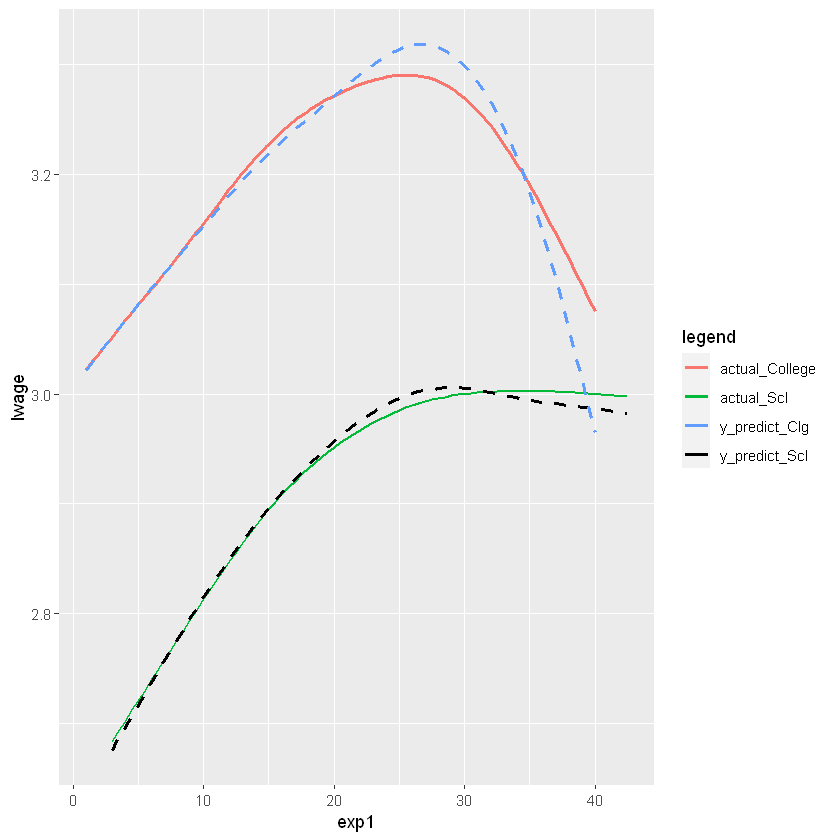

In [27]:
ggplot(data = data_1_scl, aes(x = exp1),xlim=c(1,5),axis(1, at = 1:15)) + 
    geom_smooth(aes(y = lwage, colour = "actual_Scl"), 
               fill="blue",size=.7,se=F) + 
    geom_smooth(aes(y = y_predict, colour = "y_predict_Scl"), 
               fill="red",size=1,se=F,linetype = "dashed") + 
    geom_smooth(data=data_1_clg,aes(y = lwage, colour = "actual_College"), 
               fill="blue",size=1,se=F) + 
    geom_smooth(data=data_1_clg,aes(y = y_predict, colour = "y_predict_Clg"), 
               fill="black",size=1,se=F,linetype = "dashed")+scale_color_manual(name="legend",values = c(scales::hue_pal()(3), "black"))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


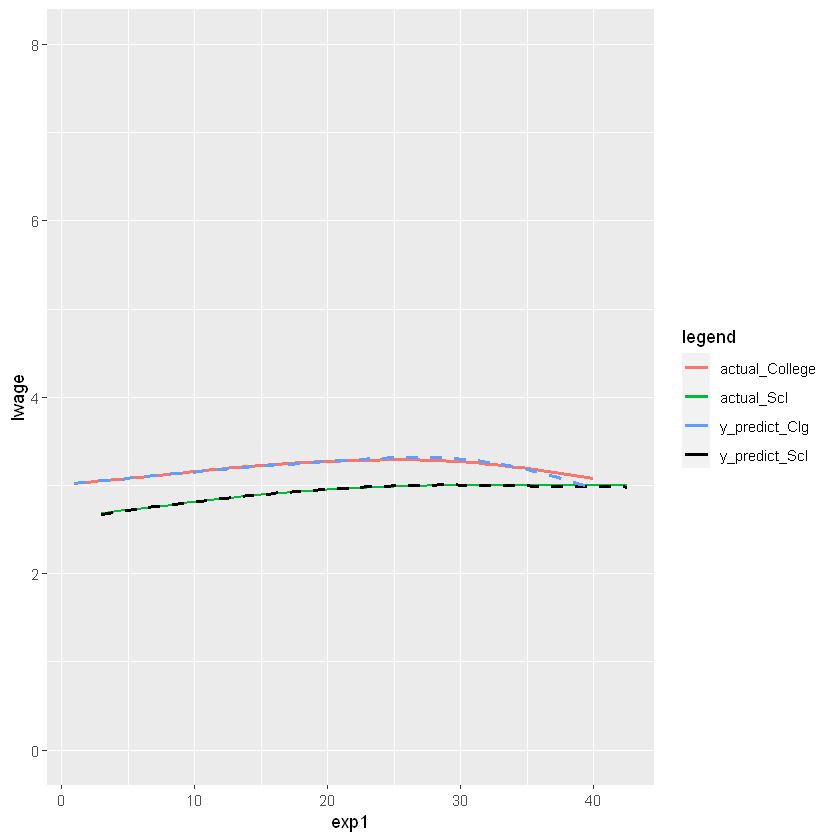

In [28]:
#limitando  x, y
ggplot(data = data_1_scl, aes(x = exp1)) + 
    geom_smooth(aes(y = lwage, colour = "actual_Scl"), 
               fill="blue",size=.7,se=F) + 
    geom_smooth(aes(y = y_predict, colour = "y_predict_Scl"), 
               fill="red",size=1,se=F,linetype = "dashed") + 
    geom_smooth(data=data_1_clg,aes(y = lwage, colour = "actual_College"), 
               fill="blue",size=1,se=F) + 
    geom_smooth(data=data_1_clg,aes(y = y_predict, colour = "y_predict_Clg"), 
               fill="black",size=1,se=F,linetype = "dashed")+lims( y = c(0, 8))+scale_color_manual(name="legend",values = c(scales::hue_pal()(3), "black"))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


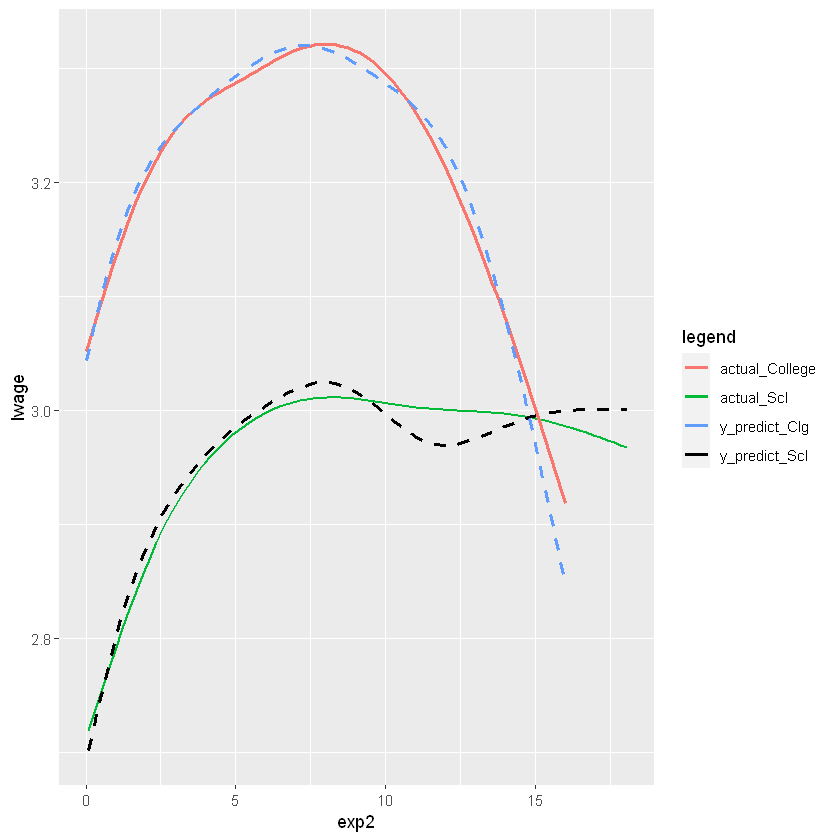

In [30]:
ggplot(data = data_1_scl, aes(x = exp2),xlim=c(1,5),axis(1, at = 1:15)) + 
    geom_smooth(aes(y = lwage, colour = "actual_Scl"), 
               fill="blue",size=.7,se=F) + 
    geom_smooth(aes(y = y_predict, colour = "y_predict_Scl"), 
               fill="red",size=1,se=F,linetype = "dashed") + 
    geom_smooth(data=data_1_clg,aes(y = lwage, colour = "actual_College"), 
               fill="blue",size=1,se=F) + 
    geom_smooth(data=data_1_clg,aes(y = y_predict, colour = "y_predict_Clg"), 
               fill="black",size=1,se=F,linetype = "dashed")+scale_color_manual(name="legend",values = c(scales::hue_pal()(3), "black"))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


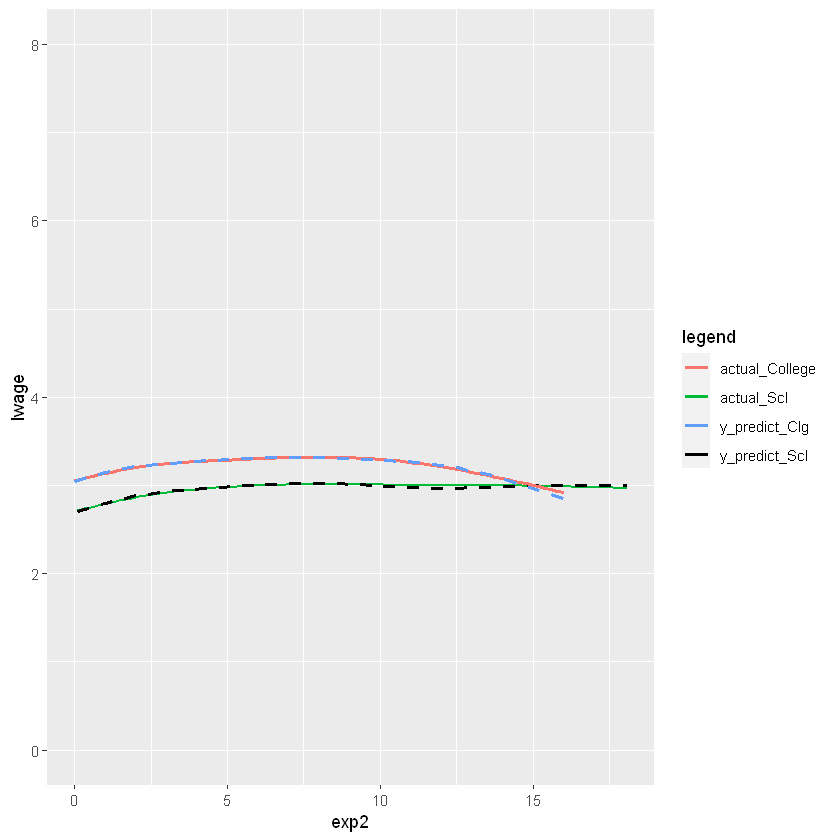

In [31]:
#limitando  x, y
ggplot(data = data_1_scl, aes(x = exp2)) + 
    geom_smooth(aes(y = lwage, colour = "actual_Scl"), 
               fill="blue",size=.7,se=F) + 
    geom_smooth(aes(y = y_predict, colour = "y_predict_Scl"), 
               fill="red",size=1,se=F,linetype = "dashed") + 
    geom_smooth(data=data_1_clg,aes(y = lwage, colour = "actual_College"), 
               fill="blue",size=1,se=F) + 
    geom_smooth(data=data_1_clg,aes(y = y_predict, colour = "y_predict_Clg"), 
               fill="black",size=1,se=F,linetype = "dashed")+lims( y = c(0, 8))+scale_color_manual(name="legend",values = c(scales::hue_pal()(3), "black"))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


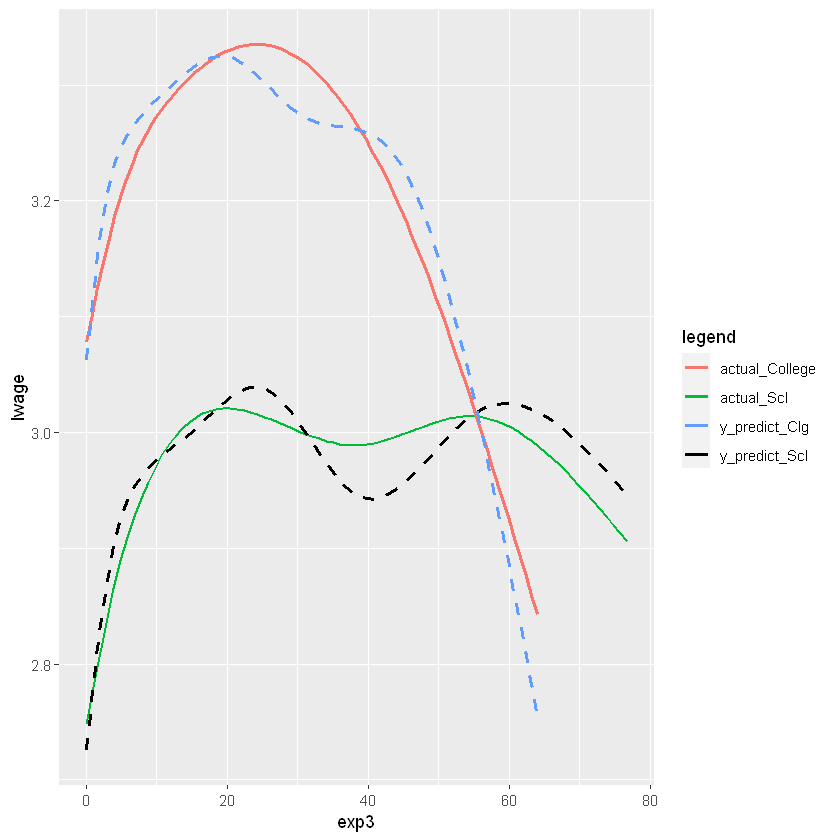

In [32]:
ggplot(data = data_1_scl, aes(x = exp3),xlim=c(1,5),axis(1, at = 1:15)) + 
    geom_smooth(aes(y = lwage, colour = "actual_Scl"), 
               fill="blue",size=.7,se=F) + 
    geom_smooth(aes(y = y_predict, colour = "y_predict_Scl"), 
               fill="red",size=1,se=F,linetype = "dashed") + 
    geom_smooth(data=data_1_clg,aes(y = lwage, colour = "actual_College"), 
               fill="blue",size=1,se=F) + 
    geom_smooth(data=data_1_clg,aes(y = y_predict, colour = "y_predict_Clg"), 
               fill="black",size=1,se=F,linetype = "dashed")+scale_color_manual(name="legend",values = c(scales::hue_pal()(3), "black"))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


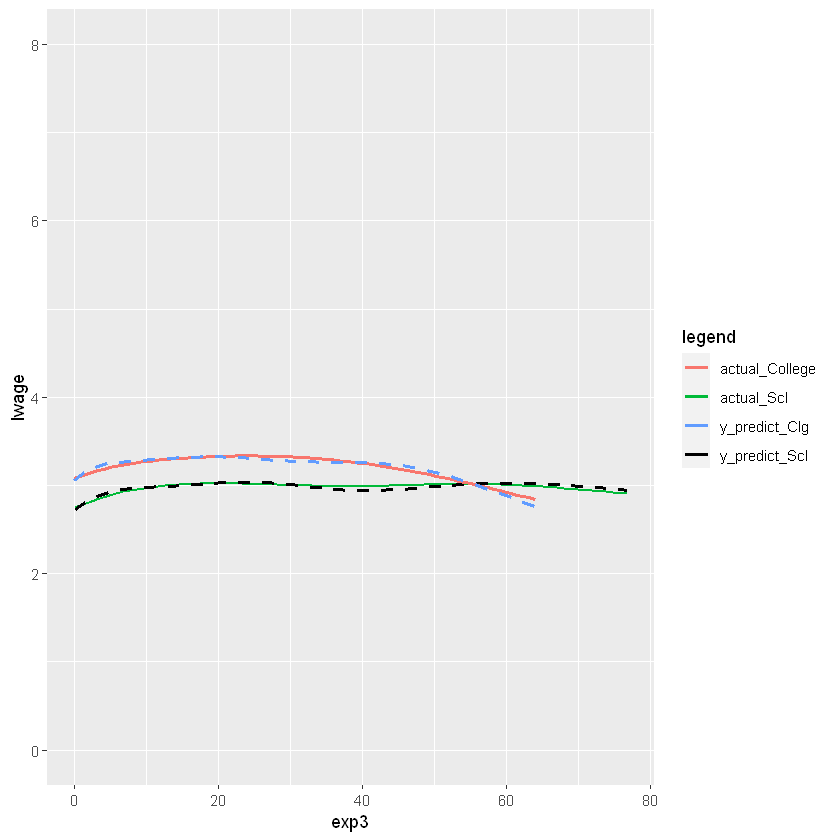

In [33]:
#limitando  x, y
ggplot(data = data_1_scl, aes(x = exp3)) + 
    geom_smooth(aes(y = lwage, colour = "actual_Scl"), 
               fill="blue",size=.7,se=F) + 
    geom_smooth(aes(y = y_predict, colour = "y_predict_Scl"), 
               fill="red",size=1,se=F,linetype = "dashed") + 
    geom_smooth(data=data_1_clg,aes(y = lwage, colour = "actual_College"), 
               fill="blue",size=1,se=F) + 
    geom_smooth(data=data_1_clg,aes(y = y_predict, colour = "y_predict_Clg"), 
               fill="black",size=1,se=F,linetype = "dashed")+lims( y = c(0, 8))+scale_color_manual(name="legend",values = c(scales::hue_pal()(3), "black"))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


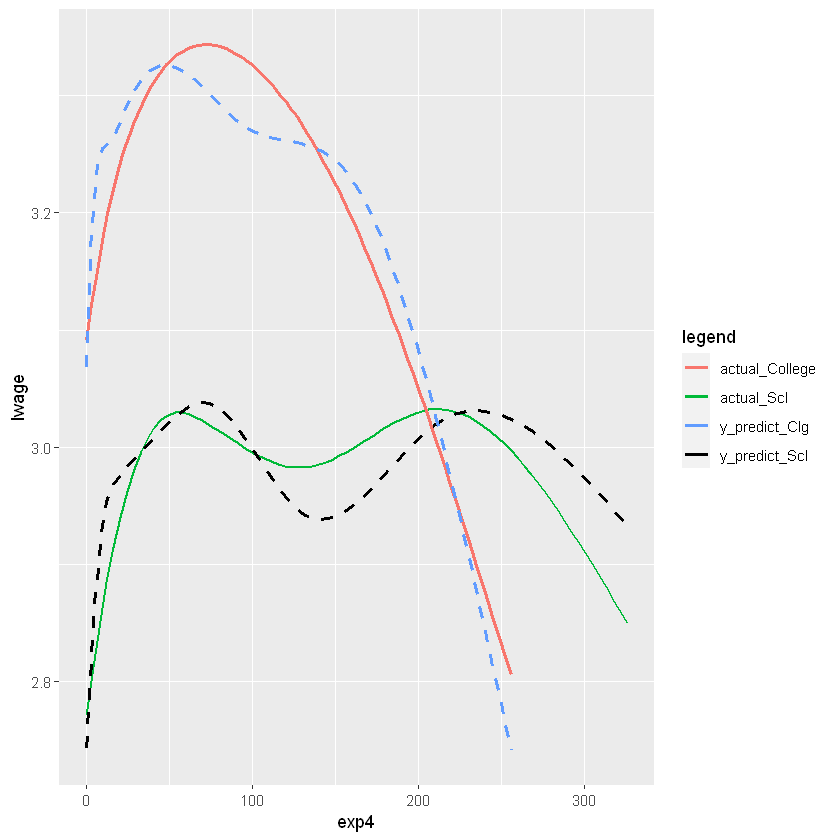

In [34]:
ggplot(data = data_1_scl, aes(x = exp4),xlim=c(1,5),axis(1, at = 1:15)) + 
    geom_smooth(aes(y = lwage, colour = "actual_Scl"), 
               fill="blue",size=.7,se=F) + 
    geom_smooth(aes(y = y_predict, colour = "y_predict_Scl"), 
               fill="red",size=1,se=F,linetype = "dashed") + 
    geom_smooth(data=data_1_clg,aes(y = lwage, colour = "actual_College"), 
               fill="blue",size=1,se=F) + 
    geom_smooth(data=data_1_clg,aes(y = y_predict, colour = "y_predict_Clg"), 
               fill="black",size=1,se=F,linetype = "dashed")+scale_color_manual(name="legend",values = c(scales::hue_pal()(3), "black"))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


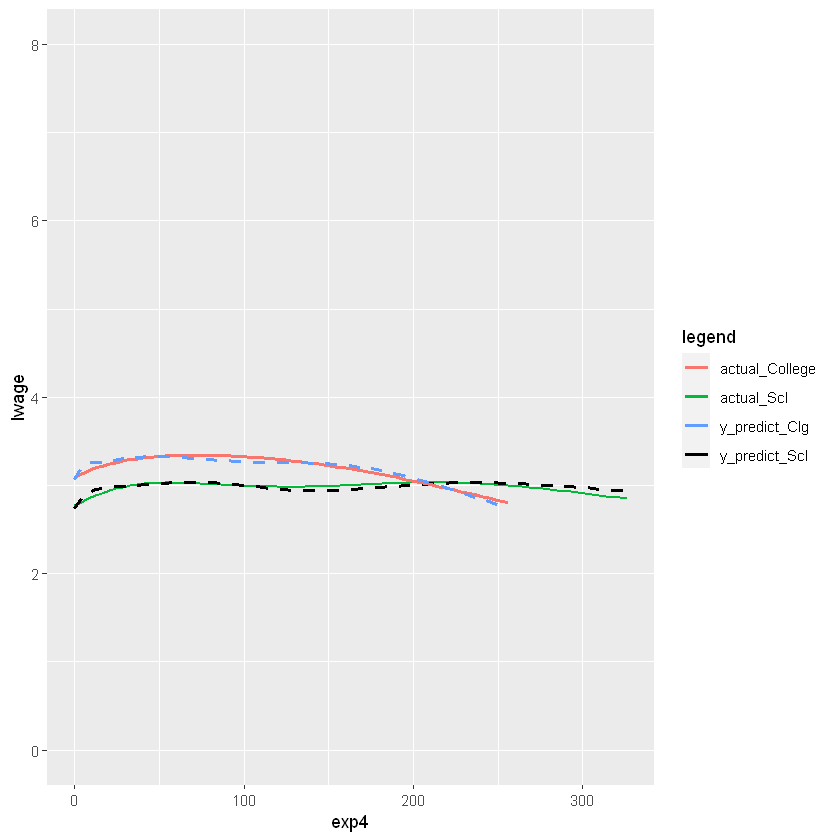

In [35]:
#limitando  x, y
ggplot(data = data_1_scl, aes(x = exp4)) + 
    geom_smooth(aes(y = lwage, colour = "actual_Scl"), 
               fill="blue",size=.7,se=F) + 
    geom_smooth(aes(y = y_predict, colour = "y_predict_Scl"), 
               fill="red",size=1,se=F,linetype = "dashed") + 
    geom_smooth(data=data_1_clg,aes(y = lwage, colour = "actual_College"), 
               fill="blue",size=1,se=F) + 
    geom_smooth(data=data_1_clg,aes(y = y_predict, colour = "y_predict_Clg"), 
               fill="black",size=1,se=F,linetype = "dashed")+lims( y = c(0, 8))+scale_color_manual(name="legend",values = c(scales::hue_pal()(3), "black"))

## **The proof of the Frisch-Waugh-Lovell Theorem**

We have the following matrix model : $ Y = X\beta +\epsilon\ \hspace{1cm} ... (1)$

If the matrix $ X=\begin{pmatrix}D & W\end{pmatrix}$ y la matriz  $\beta=\begin{pmatrix}\beta_1 \\ \beta_2\end{pmatrix}$

Then the model becomes in : $ Y =D \beta_1+W \beta_2+\epsilon\ \hspace{1cm}...(2)$

#### **Preliminary Notions**

$(a)\hspace{1cm} \gamma_{vw} = \ arg \ min_{b\in\mathbb{R}^p}\ E(V-W b)^{2}\ \rightarrow \gamma_{vw} = E(W^\prime\ W)^{-1} E(W^\prime V)$

$(b)\hspace{1cm}  \widetilde V = V - W\gamma_{vw}$

$\hspace{1cm}$ Replacing $\gamma_{vw}$ en $(b)$

 $\hspace{1cm} \widetilde V = V - E(W^\prime W)^{-1} E(W^\prime V) \rightarrow \widetilde V = (I- E(W^\prime W)^{-1} E(W^\prime))V$

$(c)\hspace{1cm}$ If $\ M_{w} = (I- E[W]E[W^\prime W]^{-1}E[W^\prime]) \rightarrow \widetilde V =M_{w}V)$


$(d)\hspace{1cm} Y=V+U \rightarrow \widetilde Y= \widetilde V + \widetilde U $ 

#### **Obtaining the estimated coefficient $\beta_1$ via Partialling-Out**

Using $(d)$ in $(2)$, we obtain :  $\widetilde Y= \widetilde D \beta_1+ \widetilde W\beta_2 +\widetilde\epsilon\ $

Regress Y on W , obtain residuals :  $\widetilde Y = Y - W\gamma_{yw}$

Regress D on W , obtain residuals : $\widetilde D = D - W\gamma_{dw}$

Regress W on W , obtain residuals : $\widetilde W = W - W\gamma_{ww}$

* We know that $\gamma_{ww} = 1 \rightarrow \widetilde W =0$

Regress $\epsilon$ on W , obtain residuals :  $\widetilde\epsilon = \epsilon - W\gamma_{\epsilon w}$

* $\gamma_{\epsilon w} = E(W^\prime\ W)^{-1} E(W^\prime\epsilon)$

* Because the regressors and residuals are orthogonal, then we have $ E(W^\prime\epsilon)=0 \rightarrow \gamma_{\epsilon w} =0 \rightarrow \widetilde\epsilon = \epsilon  $

Therefore, the residuals of the regression of Y on W and D on W are as follows: 

* $\widetilde Y= \widetilde D \beta_1 +\epsilon\ $

* $\widetilde D = D - W \gamma_{dw}$

Then, the last step is to regress $\widetilde Y$ on $\widetilde D$, obtaining the coefficient : $\gamma_{yd} = E(\widetilde D^\prime\widetilde D)^{-1} E(\widetilde D^\prime\widetilde Y)$

Using $(c)$, we have :  $\widetilde Y = M_{w}Y$  and  $\widetilde D = M_{w}D$ 

So $\gamma_{yd} = E(D^\prime M_{w}^\prime M_{w}D)^{-1} E(D^\prime M_{w}^\prime M_{w}Y)$

By property of the matrix M, we Know that $ M_{w}^\prime M_{w}= M_{w}$

 $\gamma_{yd} = E(D^\prime M_{w}^\prime M_{w}D)^{-1} E(D^\prime M_{w}^\prime M_{w}Y) = E(D^\prime M_{w}D)^{-1} E(D^\prime M_{w}Y)$


#### **Obtaining the estimated coefficient $\beta_1$ via OLS**

Using $(1)$ model:  $ Y = X\beta +\epsilon$

Using $(a)$ : $\hat{\beta}=E(X^\prime X)^{-1} E(X^\prime Y)\hspace{1cm}...(3)$

Replace $X$ as a partitioned matrix: $X=\begin{pmatrix}D & W\end{pmatrix}$  en  $(3)$ and solve:

<div style="text-align: center"> 

$ \begin{pmatrix}\hat{\beta_1} \\ \hat{\beta_2}\end{pmatrix} = E[\begin{pmatrix} D^\prime \\ W^\prime \end{pmatrix} \begin{pmatrix}D & W \end{pmatrix}]^{-1} E[\begin{pmatrix} D^\prime \\ W^\prime \end{pmatrix}  Y]$

$  \begin{pmatrix}\hat{\beta_1} \\ \hat{\beta_2}\end{pmatrix} = E[\begin{pmatrix}D^\prime D & D^\prime W \\ W^\prime D & W^\prime W \end{pmatrix}]^{-1} E[\begin{pmatrix} D^\prime Y \\ W^\prime Y \end{pmatrix}]$


$ E[\begin{pmatrix}D^\prime D & D^\prime W \\ W^\prime D & W^\prime W \end{pmatrix}] \begin{pmatrix}\hat{\beta_1} \\ \hat{\beta_2}\end{pmatrix}=  E[\begin{pmatrix} D^\prime Y \\ W^\prime Y \end{pmatrix}]$

$\begin{pmatrix}E [D^\prime D] & E[D^\prime W] \\ E[W^\prime D] & E[W^\prime W] \end{pmatrix} \ \begin{pmatrix}\hat{\beta_1} \\ \hat{\beta_2}\end{pmatrix} =  \begin{pmatrix} E[D^\prime Y] \\  E[W^\prime Y] \end{pmatrix}]$

$\begin{pmatrix}E [D^\prime D]\hat{\beta_1} & E[D^\prime W]\hat{\beta_2} \\ E[W^\prime D]\hat{\beta_1} & E[W^\prime W]\hat{\beta_2} \end{pmatrix} =  \begin{pmatrix} E[D^\prime Y] \\  E[W^\prime Y] \end{pmatrix}]$
</div>

We obtain the following equations:

* $E [D^\prime D]\hat{\beta_1} + E[D^\prime W]\hat{\beta_2}= E[D^\prime Y]$

* $E[W^\prime D]\hat{\beta_1} + E[W^\prime W]\hat{\beta_2}= E[W^\prime Y]$

We isolate $\hat{\beta_2}$ from the second equation:

$\hat{\beta_2} = E[W^\prime W]^{-1}(E[W^\prime Y - E[W^\prime D]\hat{\beta_1})$

We replace $\hat{\beta_2}$ in the first equation to obtain $\hat{\beta_1}$ 

$E [D^\prime D]\hat{\beta_1} + E[D^\prime W]E[W^\prime W]^{-1}(E[W^\prime Y - E[W^\prime D]\hat{\beta_1})= E[D^\prime Y]$


$(E [D^\prime D]- E[D^\prime W]E[W^\prime W]^{-1}E[W^\prime D])\hat{\beta_1}= E[D^\prime Y] -  E[D^\prime W]E[W^\prime W]^{-1}E[W^\prime Y]$

$E [D^\prime] (I- E[W]E[W^\prime W]^{-1}E[W^\prime])D\hat{\beta_1}= E [D^\prime] (I- E[W]E[W^\prime W]^{-1}E[W^\prime])Y$

We use $(c)$ : $M_{w} = (I- E[W]E[W^\prime W]^{-1}E[W^\prime]) $ and replace $M_{w}$ in the equation, we obtain:

 $E [D^\prime] M_{w}D\hat{\beta_1}= E [D^\prime] M_{w}Y$

We isolate $\hat{\beta_1}$

$\hat{\beta_1}= (E[D^\prime] M_{w}D)^{-1} E [D^\prime] M_{dw}Y$

$\hat{\beta_1}= E[D^\prime M_{w}D]^{-1} E [D^\prime M_{dw}Y]$

 Finally, we see : $\gamma_{yd}=\hat{\beta_1}$